In [41]:
import numpy as np
from ekpy.analysis import plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from os import listdir
plt.style.use(plotting.lane_martin)

In [2]:
def find_datafiles(directories):
    datafiles = []
    file_labels = {}
    for directory in directories:
        for item in listdir('.\%s'%directory):
            if item.find('data.xlsx')!=-1:
                datafile = '.\\%s\\%s'%(directory,item)
                datafiles.append(datafile)
                file_labels['%s'%(datafile)] = item[0:item.find('_data.xlsx')]
    return datafiles, file_labels #file_labels is indexed by items in datafiles
        

In [3]:
def read_data(data_file_name): #for the new data, data taken with Eric's new code setup
    sample_columns = "A,B,C,D,E"
    device_columns = "A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R"
    sample_data = pd.read_excel(data_file_name,
                                         usecols = sample_columns,
                                         skiprows = 1,
                                         nrows = 1)
    device_data = pd.read_excel(data_file_name,
                                usecols = device_columns,
                                skiprows = 3)
    return {'specs': sample_data, 'devices': device_data}
    

In [4]:
def read_old_data(data_file_name): #for the old data. Does not include Power information, and does not include dOffset.
    sample_columns = "O,P,Q,R,S"
    device_columns = "A,B,C,D,E,F,G,H,I,J,K,L,M"
    sample_data = pd.read_excel(data_file_name,
                                usecols = sample_columns,
                                skiprows = 1,
                                nrows = 1)
    old = pd.read_excel(data_file_name,
                                usecols = device_columns)
    #Now we reformat so the format matches the format of the newer data:
    device_data = {'Filename':old['Filename']}
    device_data['Sample'] = old['Device']
    device_data['Frequency'] = old['Frequency (GHz)']
    #device_data['Power'] = 'nan'
    #device_data['Trial'] = 'nan'
    #device_data['Count'] = 'nan'
    #device_data['Sleep'] = 'nan'
    device_data['S'] = old['S']
    device_data['dS']=old['S_err']
    device_data['A']=old['A']
    device_data['dA']=old['A_err']
    device_data['W']=old['W (Oe)']
    device_data['dW']=old['W_err']
    device_data['H0']=old['H0']
    device_data['dH0']=old['H0_err']
    device_data['Offset']=old['Offset']
    #device_data['dOffset']='nan'
    device_data['label']=old['Label']
    return {'specs': sample_data, 'devices': pd.DataFrame(device_data)}
    

In [35]:
g_e = 2.0 #lande g factor for electron
bohr_mag = 9.274e-21 #erg/G, CGS units
hbar = 1.055e-27 #erg*s, CGS units
gyromagnetic_ratio = g_e * bohr_mag/hbar # = 1.76e7 1/Gs so 
mu_naught = 4*np.pi #CGS (emu) units
e = 1.602e-20 #abC, or Abcoulomb. CGS units.


def kittel_equation(B,Meff,Hanis):
    return (gyromagnetic_ratio/(2*np.pi*1e9))*np.sqrt((B+Hanis)*(B+Hanis+mu_naught*Meff))

def SHA(S,A,Ms,t,d,Meff,Bres): #everything must be in CGS units
    temp_SHA = (S/A)*(e*mu_naught*Ms*t*d/hbar)*np.sqrt(1+mu_naught*Meff/np.abs(Bres))
    if Bres > 0: return -1.0*temp_SHA
    if Bres < 0: return temp_SHA
    #return temp_SHA 
        
def root_sum_squares(any_list):
    sum_squares = 0
    for item in any_list:
        sum_squares += item**2
    return np.sqrt(sum_squares)

def calculate_SHAs(sample): #sample should be a dictionary
    SHAs = []
    dSHAs = []
    for i in range(len(sample['devices']['S'])):
        spin_Hall_angle = SHA(sample['devices']['S'][i],
                           sample['devices']['A'][i],
                           sample['specs']['LSMO Ms'],
                           sample['specs']['BPBO-thick'],
                           sample['specs']['LSMO-thick'],
                           sample['specs']['LSMO Meff'],
                           sample['devices']['H0'][i])
        SHAs.append(float(spin_Hall_angle))
        uncertainties = [sample['devices']['dA'][i]/sample['devices']['A'][i],
                         1e-7/sample['specs']['BPBO-thick'],
                         1e-7/sample['specs']['LSMO-thick'],
                         sample['devices']['dS'][i]/sample['devices']['S'][i]]
        dSHAs.append(float(np.abs(spin_Hall_angle) * root_sum_squares(uncertainties)))
    SHA_dataFrame = pd.DataFrame({'SHA': SHAs, 'dSHA': dSHAs})
    #display(SHA_dataFrame)
    new_devices_frame = pd.concat([sample['devices'],SHA_dataFrame],axis=1,join = 'inner')
    return {'specs': sample['specs'],'devices': new_devices_frame}

def kittel_fit(sample):
    popt, pcov = curve_fit(kittel_equation,
                           np.abs(sample['devices']['H0']),
                           sample['devices']['Frequency'],
                           p0 = [300,20],
                           maxfev = 1000)
    perr = np.sqrt(np.diag(pcov))
    Meff, Hanis = popt[0], popt[1]
    dMeff, dHanis = perr[0],perr[1]
    return Meff, dMeff, Hanis, dHanis


In [89]:
def conditions_on_SHAs(sample):
    old = sample['devices']
    #all conditions must be true for good SHAs.
    condition = (old['dSHA']/old['SHA']<0.3)
    condition &= (old['SHA']>0)
    new_df = old.loc[condition]
    return new_df


finished 051022a
finished 050322a-STO
finished 012622a-STO


C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\U

finished 020722b-STO
finished 032822-LSAT


C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])


finished 050422-STO
finished 111621b
finished 111721
finished 120621


C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])


finished 120721
finished 120821a
finished annealed_012622a-STO


C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])


finished annealed_032822-STO
finished annealed_111621b-STO
finished annealed_111721-STO
finished annealed_120621-STO


C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\Users\Isaac\AppData\Local\Temp\ipykernel_16936\1300110493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
C:\U

finished annealed_120721-STO
finished annealed_120821a-STO


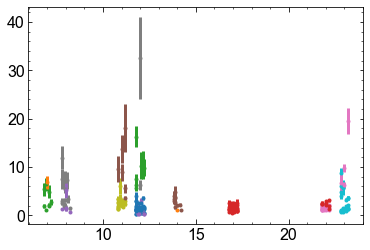

In [90]:
#This makes the large SOTscatterplot with all of the data.
def frequency_adjusted_thicknesses(thickness,frequencies):
    datapoint_spread = 0.4
    minFreq = min(frequencies)
    maxFreq = max(frequencies)
    midFreq = (minFreq+maxFreq)*0.5
    Freq_range = maxFreq-minFreq
    frequency_adjusted_thicknesses = []
    for frequency in frequencies:
        if Freq_range !=0: offset_normalized = (frequency - midFreq)/Freq_range
        else: offset_normalized = 0
        frequency_adjusted_thicknesses.append(thickness*1e7+datapoint_spread*offset_normalized) #also converts to nm
    return frequency_adjusted_thicknesses
        

directories = ['BPBO-LSMO\\051022a','BPBO-LSMO\\050322a','old_format\\BPBO-LSMO']
datafiles,file_labels = find_datafiles(directories) 
SOTscatter_fig, SOTscatter_ax = plt.subplots()
for datafile in datafiles:
    if datafile[0:6] == '.\old_': sample = read_old_data(datafile)
    else: sample = read_data(datafile)
    sample = calculate_SHAs(sample)
    sample['SHA-conditions'] = conditions_on_SHAs(sample)
    print('finished %s' %file_labels[datafile])
    #display(sample)
    sample['SHA-conditions']['f_a_ts'] = frequency_adjusted_thicknesses(sample['specs']['BPBO-thick'][0],sample['SHA-conditions']['Frequency'])
    x = sample['SHA-conditions']['f_a_ts']
    y = sample['SHA-conditions']['SHA']
    yerr = sample['SHA-conditions']['dSHA']
    #print(x,y,yerr)
    SOTscatter_ax.errorbar(x,y,yerr,linestyle = '',marker = '.')

050322a-STO mean SHA: 3.14 +/- 2.0
050322a-STO Meff: 332.0 +/- 3.4
050322a-STO Hanis: 26.9 +/- 2.8


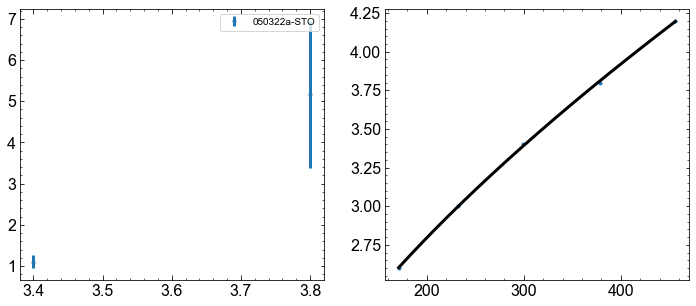

In [78]:
#this plots SHAs for individual devices vs. frequency and does kittel fits.
directories = ['BPBO-LSMO\\050322a']
datafiles,file_labels = find_datafiles(directories) 
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (12,5))
for datafile in datafiles:
    if datafile[0:6] == '.\old_': sample = read_old_data(datafile)
    else: sample = read_data(datafile)
    sample = calculate_SHAs(sample)
    sample['SHA-conditions'] = conditions_on_SHAs(sample)
    x = sample['SHA-conditions']['Frequency']
    y = sample['SHA-conditions']['SHA']
    yerr = sample['SHA-conditions']['dSHA']
    ax1.errorbar(x,y,yerr,label = file_labels[datafile], linestyle = '',marker = '.')
    print(r'%s mean SHA: %.2f +/- %.1f'%(file_labels[datafile],np.mean(y), np.std(y)))
ax1.legend()


for datafile in datafiles:
    if datafile[0:6] == '.\old_': sample = read_old_data(datafile)
    else: sample = read_data(datafile)
    sample = calculate_SHAs(sample)
    sample['SHA-conditions'] = conditions_on_SHAs(sample)
    
    Meff,dMeff, Hanis, dHanis = kittel_fit(sample)
    x1, y1 = np.abs(sample['devices']['H0']), sample['devices']['Frequency']
    ax2.plot(x1,y1,label = file_labels[datafile], marker = '.', linestyle = '')
    T = np.linspace(min(x1),max(x1),1000)
    ax2.plot(T,kittel_equation(T,Meff,Hanis),color = 'k')
    print(r'%s Meff: %.1f +/- %.1f'%(file_labels[datafile],Meff, dMeff))
    print(r'%s Hanis: %.1f +/- %.1f'%(file_labels[datafile],Hanis, dHanis))

Text(0, 0.5, 'SOT Efficiency')

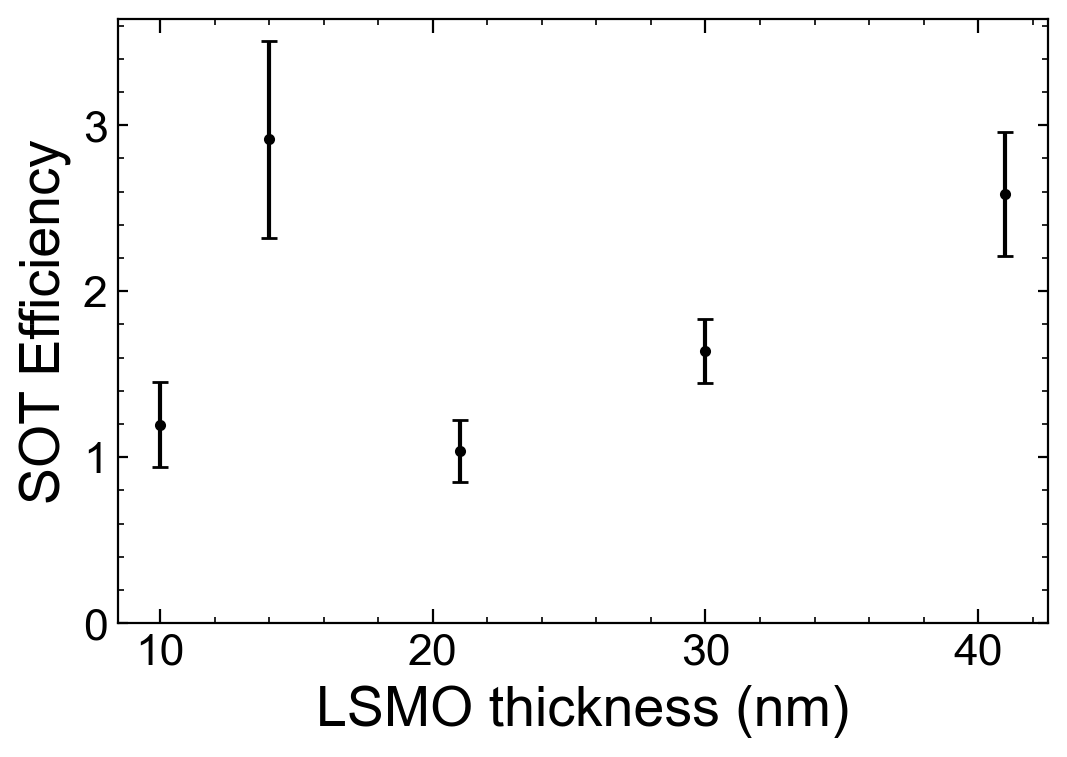

In [66]:
#This makes a thickness series
directories = ['BPBO-LSMO\\051022a','old_format\\BPBO-LSMO\\thickness_series']
datafiles,file_labels = find_datafiles(directories) 
Lthick_fig, Lthick_ax = plt.subplots(dpi = 200)
for datafile in datafiles:
    if datafile[0:6] == '.\old_': sample = read_old_data(datafile)
    else: sample = read_data(datafile)
    sample = calculate_SHAs(sample)
    sample['SHA-conditions'] = conditions_on_SHAs(sample)
    
    xx = sample['specs']['LSMO-thick']*1e7 #units nm
    yy = np.mean(sample['SHA-conditions']['SHA'])
    yyerr = max(np.mean(sample['SHA-conditions']['dSHA']),np.std(sample['SHA-conditions']['SHA'])/len(sample['SHA-conditions']['SHA']))
    Lthick_ax.errorbar(xx,yy,yyerr, color = 'k', marker = '.', capsize = 3, linestyle = '', linewidth = 1.5)
Lthick_ax.set_ylim((0,None))
Lthick_ax.set_xlabel('LSMO thickness (nm)')
Lthick_ax.set_ylabel(r'SOT Efficiency')
    

In [68]:
#figure_filename = '.\\figures\\LSMO-thick_series_051822.png'
Lthick_fig.savefig(figure_filename,bbox_inches='tight') #transparent=True